# Brazillian E-Commerce Dataset
(Downloaded from [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce))

**About the data:**
> The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

**About Olist.com**
> This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

**Attention**
- An order might have multiple items.
- Each item might be fulfilled by a distinct seller.
- All text identifying stores and partners where replaced by the names of Game of Thrones great houses.

**Schema**
<img src="figures/ds-schema.png" style="width: 600px;">

### Description of columns

| Dataset | Column  | Description  |
| --- | --- | --- |
| *Orders* | order_id | unique identifier of the order. |
| *Orders* | customer_id | key to the customer dataset. Each order has a unique customer_id. |
| *Orders* | order_status | Reference to the order status (delivered, shipped, etc). |
| *Orders* | order_purchase_timestamp | Shows the purchase timestamp. |
| *Orders* | order_approved_at | Shows the payment approval timestamp. |
| *Orders* | order_delivered_carrier_date | Shows the order posting timestamp. When it was handled to the logistic partner. |
| *Orders* | order_delivered_customer_date | Shows the actual order delivery date to the customer. |
| *Orders* | order_estimated_delivery_date | Shows the estimated delivery date that was informed to customer at the purchase moment. |
| --- | --- | --- |
| *Payments* | payment_sequential | a customer may pay with more than one payment method. If so, a sequence will be created to accommodate all payments. |
| *Payments* | payment_type | method of payment chosen by the customer. |
| *Payments* | payment_installments | number of installments chosen by the customer. |
| *Payments* | payment_value | transaction value. |
| --- | --- | --- |
| *Reviews* | review_id | unique review identifier |
| *Reviews* | review_score | Note ranging from 1 to 5 given by the customer on a satisfaction survey. |
| *Reviews* | review_comment_title | Comment title from the review left by the customer, in Portuguese. |
| *Reviews* | review_comment_message | Comment message from the review left by the customer, in Portuguese. |
| *Reviews* | review_creation_date | Shows the date in which the satisfaction survey was sent to the customer. |
| *Reviews* | review_answer_timestamp | Shows satisfaction survey answer timestamp. |
| --- | --- | --- |
| *Items* | order_item_id | sequential number identifying number of items included in the same order. |
| *Items* | product_id | product unique identifier |
| *Items* | seller_id | seller unique identifier |
| *Items* | shipping_limit_date | Shows the seller shipping limit date for handling the order over to the logistic partner. |
| *Items* | price | item price |
| *Items* | freight_value | item freight value item (if an order has more than one item the freight value is splitted between items) |
| --- | --- | --- |
| *Products* | product_category_name | root category of product, in Portuguese. |
| *Products* | product_name_lenght | number of characters extracted from the product name. |
| *Products* | product_description_lenght | number of characters extracted from the product description. |
| *Products* | product_photos_qty | number of product published photos |
| *Products* | product_weight_g | product weight measured in grams. |
| *Products* | product_length_cm | product length measured in centimeters. |
| *Products* | product_height_cm | product height measured in centimeters. |
| *Products* | product_width_cm | product width measured in centimeters. |
| --- | --- | --- |
| *Customers* | customer_id | key to the orders dataset. Each order has a unique customer_id. |
| *Customers* | customer_unique_id | unique identifier of a customer. |
| *Customers* | customer_zip_code_prefix | first five digits of customer zip code |
| *Customers* | customer_city | customer city name |
| *Customers* | customer_state | customer state |
| --- | --- | --- |
| *Sellers* | seller_id | seller unique identifier |
| *Sellers* | seller_zip_code_prefix | first 5 digits of seller zip code |
| *Sellers* | seller_city | seller city name |
| *Sellers* | seller_state | seller state |

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import geopandas
import geoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# pandas params
pd.options.display.max_rows = 100

# matplotlib params 
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

# matplotlib adjustments
def default_plot(ax, spines): 
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax

# brazilian map plot
def brazil_map(df, colormap, cb_label):
    
    # receives a dataframe with data by country and makes a heat-world map based on the data
    
    # get geographical shape data
    brazil = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/bra_adm1/BRA_adm1.shp')[['HASC_1','geometry']]
    brazil['HASC_1'] = [x[3:] for x in brazil['HASC_1']]
    
    # merge both datasets on country names
    
    data_merge = brazil.merge(df, left_on= 'HASC_1', right_on='state')
    
    brazil['coords'] = brazil['geometry'].apply(lambda x: x.representative_point().coords[:])
    brazil['coords'] = [coords[0] for coords in brazil['coords']]
 
    # plot the base map with black lines
    base = brazil.plot(figsize=(10, 8), color='white', edgecolor='black', lw= 1, alpha=0.5)
    
    bbox_props = dict(boxstyle='round,pad=0.25', fc='white', ec='black')
    
    for idx, row in brazil.iterrows():
        base.text(s=row['HASC_1'], x=row['coords'][0]-1, y=row['coords'][1], horizontalalignment='center', bbox = bbox_props, fontsize=10)
    
    
    divider = make_axes_locatable(base)
    cax = divider.append_axes("right", size="2%", pad=0.1)
       
    # make the heatmap on top of base map
    data_merge.plot(ax=base, column= df.columns[-1], legend= True, cmap=colormap, cax= cax, legend_kwds= {'label': cb_label})
   
    base.axis('off')
    
    plt.savefig('figures/' + cb_label + '.png', dpi=300)

In [3]:
data_path = 'C:/Users/Zaca/Documents/Datasets/brazilian-ecommerce/olist_'

In [4]:
# opening datasets individually (ignored customers and sellers)
orders = pd.read_csv(data_path + 'orders_dataset.csv')
items = pd.read_csv(data_path + 'order_items_dataset.csv')
products = pd.read_csv(data_path + 'products_dataset.csv')
payments = pd.read_csv(data_path + 'order_payments_dataset.csv')
reviews = pd.read_csv(data_path + 'order_reviews_dataset.csv')
customers = pd.read_csv(data_path + 'customers_dataset.csv')
sellers = pd.read_csv(data_path + 'sellers_dataset.csv')

data = {'orders': orders,
        'items': items, 
        'products': products,
        'payments': payments,
        'reviews': reviews,
        'customers': customers,
        'sellers': sellers}

## Data cleaning

### Orders
- This is the most important data set as its like a *linking table*, and is connected to a lot of other datatsets by *order_id*.

In [5]:
print('Order cols: ' , data['orders'].columns.values)

# i've decided I'm not interested in order_approved, and order_delivered_carrier_date
orders_drop_cols = ['order_approved_at', 
                    'order_delivered_carrier_date']

data['orders'].drop(orders_drop_cols, axis= 1, inplace= True)

Order cols:  ['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date']


In [6]:
# for the purpose of this analysis I'll be selecting only orders that have been in fact, delivered
print(data['orders']['order_status'].value_counts())

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


In [7]:
print('Taking only delivered orders we still get ' + 
      str(round((data['orders'].order_status.value_counts()['delivered']/len(data['orders']))*100,2)) +
      '% of data.')

Taking only delivered orders we still get 97.02% of data.


In [8]:
# first I will get all order_id where the order status was delivered
delivered = data['orders']['order_id'][data['orders']['order_status'] != 'delivered'].values

# now filter every other dataframe where order_id is a foreign key
for key, value in data.items():
    if 'order_id' in value.columns:
        value.drop(value.loc[value['order_id'].isin(delivered)].index, inplace = True)


In [9]:
# checking for nans in each dataset
for key, value in data.items():
    for col in value.columns:
        # print only col names where there are nans
        if value[col].isnull().sum():
            print(col + ' (%): ' + str((sum(value[col].isnull())/len(value))*100))

order_delivered_customer_date (%): 0.008292045855013579
product_category_name (%): 1.8512336499650999
product_name_lenght (%): 1.8512336499650999
product_description_lenght (%): 1.8512336499650999
product_photos_qty (%): 1.8512336499650999
product_weight_g (%): 0.006069618524475737
product_length_cm (%): 0.006069618524475737
product_height_cm (%): 0.006069618524475737
product_width_cm (%): 0.006069618524475737
review_comment_title (%): 88.32654744111736
review_comment_message (%): 59.023862289336705


In [10]:
# let's deal first with orders nans
# I've observed that these nans in the orders list are not really overlapping, and the only ones I really
# care about are the delivered_customer_date.
print('There are only ' + str(data['orders'].order_delivered_customer_date.isnull().sum()) + 
      ' orders that are missing delivery dates.')

There are only 8 orders that are missing delivery dates.


In [11]:
# we can drop them the same way as before
# first I will get all order_id where the order status was delivered
null_deliveries = data['orders']['order_id'][data['orders']['order_delivered_customer_date'].isnull()].values

# now filter every other dataframe where order_id is a foreign key
for key, value in data.items():
    if 'order_id' in value.columns:
        value.drop(value.loc[value['order_id'].isin(null_deliveries)].index, inplace = True)

In [12]:
# there are 3 date columns in the orders dataset that I will transform to datetime and keep only the date
# ignoring hours minutes and seconds
data['orders'].order_purchase_timestamp = pd.to_datetime(data['orders'].order_purchase_timestamp).dt.date
data['orders'].order_delivered_customer_date = pd.to_datetime(data['orders'].order_delivered_customer_date).dt.date
data['orders'].order_estimated_delivery_date = pd.to_datetime(data['orders'].order_estimated_delivery_date).dt.date

In [13]:
# I'm not particularly interested in the actual date of delivery, but more if it was delivered on time
data['orders']['delivered_on_time'] = np.where(data['orders'].order_delivered_customer_date < data['orders'].order_estimated_delivery_date, 1, 0)

### Reviews

In [14]:
print('Review cols: ' , data['reviews'].columns.values)

# the review_comment_title column is 88% NaN so i'll just drop it. 
# TODO: nans for reviews just means there are none (?). 
# So maybe just assume that's all there is and use the data separately for a etxt analysis (in M3) ENDTODO

# and when the review was sent to the customer
review_drop_cols = ['review_comment_title']
data['reviews'].drop(review_drop_cols, axis= 1, inplace= True)

Review cols:  ['review_id' 'order_id' 'review_score' 'review_comment_title'
 'review_comment_message' 'review_creation_date' 'review_answer_timestamp']


In [15]:
# for now I won't do any text analysis so I'm not super interested in the comment message
# it looks like in this column there are nans if people did not leave a review
# I don't want to drop the column, so I will just replace nan by 0 and the review by 1
data['reviews']['review_comment_message'] = np.where(data['reviews']['review_comment_message'].isnull(), 0, 1)

### Products

In [16]:
print('Product cols: ' , data['products'].columns.values)

# I've decided I'm not interested in the length of the name or the description of the product (too many nans)
# also I can't think of anything to do with the size attributes of each product
product_drop_cols = ['product_name_lenght', 
                     'product_description_lenght', 
                     'product_weight_g', 
                     'product_length_cm', 
                     'product_height_cm',
                     'product_width_cm']

data['products'].drop(product_drop_cols, axis= 1, inplace= True)

Product cols:  ['product_id' 'product_category_name' 'product_name_lenght'
 'product_description_lenght' 'product_photos_qty' 'product_weight_g'
 'product_length_cm' 'product_height_cm' 'product_width_cm']


In [17]:
# after looking at a gigantic list of categories for products 
# I think it's safe to assume that I can replace nans in these columns by 'other'
data['products']['product_category_name'].fillna(value='outro', inplace=True)

In [18]:
# there are no zeros in the photos_qty column, somehow I doubt there are NO products with zero photos
# will fill nans with zero in this column
data['products']['product_photos_qty'].fillna(value=0, inplace=True)

## Data Analysis
#### Which products makes more money?

In [19]:
# based on the schema, we merge the products dataset with the items dataset
items_product = data['items'].merge(data['products'], on= 'product_id', how= 'inner')
orders_ip = data['orders'].merge(items_product, on='order_id', how='inner')

# pivot table aggregating by # of items bought and mean of price ('will be the same')
product_revenue = orders_ip.pivot_table(index=['product_id'], aggfunc= {'order_item_id': 'sum', 'price':'mean'})
product_revenue['total'] = product_revenue['order_item_id'] * product_revenue['price']
product_revenue.rename(columns={'order_item_id':'sell_probability'}, inplace= True)
product_revenue['sell_probability'] = product_revenue['sell_probability'] / len(product_revenue)
product_revenue.sort_values(by='total', ascending= False)

,sell_probability,price,total
product_id,,,
bb50f2e236e5eea0100680137654686c,0.006643,327.628866,70112.577320
5769ef0a239114ac3a854af00df129e4,0.001118,1680.000000,60480.000000
6cdd53843498f92890544667809f1595,0.004998,350.668627,56457.649020
d1c427060a0f73f6b889a5c7c61f2ac4,0.011082,137.411325,49055.843133
99a4788cb24856965c36a24e339b6058,0.016484,88.154423,46809.998868
...,...,...,...
8a3254bee785a526d548a81a9bc3c9be,0.000124,0.850000,3.400000
2e8316b31db34314f393806fd7b6e185,0.000031,2.990000,2.990000
680cc8535be7cc69544238c1d6a83fe8,0.000031,2.900000,2.900000


#### Plotting product selling probability, price and revenue

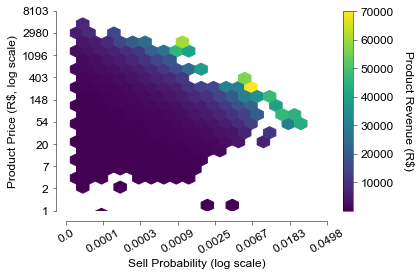

In [20]:
x = np.log(product_revenue.sell_probability)
y = np.log(product_revenue.price)

fig, ax = plt.subplots()
ax = default_plot(ax, ['left', 'bottom'])

plt.ylabel('Product Price (R$, log scale)')
plt.xlabel('Sell Probability (log scale)')

plt.xlim(-10, -3)
plt.ylim(0, 9)

plt.yticks(range(10), [int(np.exp(x)) for x in range(10)])
plt.xticks(range(-10, -2), [round(np.exp(x), 4) for x in range(-10, -2)], rotation= 30)

hb = ax.hexbin(x, y, gridsize=20, C=product_revenue.total);

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Product Revenue (R$)', rotation=270, labelpad = 20)
plt.tight_layout()
plt.savefig('figures/product_probability.png', dpi=300)

*We can say that the products that generate most revenue are mid-range items that are sold frequently.*

## Timeseries
#### Timeseries of orders
- Does *Olist* sell more during a specific time of the year?

First registered order:  2016-09-15
Last registered order:  2018-08-29


C:\Users\Zaca\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


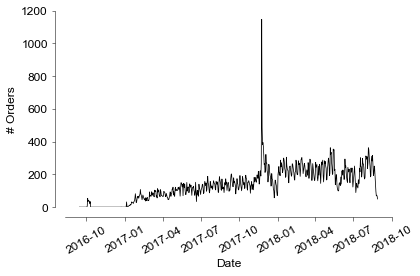

In [21]:
# purchase_timestamp also has interesting information about the frequency of orders
min_order_date = data['orders'].order_purchase_timestamp.min()
max_order_date = data['orders'].order_purchase_timestamp.max()
print('First registered order: ', min_order_date)
print('Last registered order: ', max_order_date)

# creating a list of days between the beggining of the dataset and the end.
order_dates = [min_order_date + dt.timedelta(days= i) for i in range((max_order_date - min_order_date).days)]

# I want to histogram the dates and then plot a line
# but numpy histogram only works with numbers so we need to do the following
to_timestamp = np.vectorize(lambda x: (x - dt.date(1970, 1, 1)).total_seconds())
time_stamps = to_timestamp(data['orders'].order_purchase_timestamp)
order_histogram = np.histogram(time_stamps, bins = len(order_dates))[0]

# making timeseries plot of # orders made per day
plt.subplots()
ax = default_plot(ax, ['bottom', 'left'])
ax.set_ylabel('# Orders')
ax.set_xlabel('Date')
plt.ylim(0, 1200)
plt.xticks(rotation= 30)
ax.plot(order_dates, order_histogram, 'k', lw=0.75);
plt.tight_layout()
plt.savefig('figures/orders_timeseries.png', dpi= 300)

#### Seasonal analysis

In [22]:
dates_and_counts = list(zip(order_dates, order_histogram))
print('Highest order date: ' + str(max(dates_and_counts, key=lambda x: x[1])[0]))
print('# of orders: ' + str(max(dates_and_counts, key=lambda x: x[1])[1]))

Highest order date: 2017-11-24
# of orders: 1147


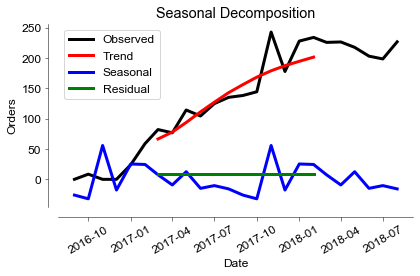

In [23]:
# place data into DataFrame
timeseries = pd.DataFrame(dates_and_counts, columns=['Date', 'Orders'])

# convert date column into datetime... again.
timeseries['Date'] = pd.to_datetime(timeseries['Date'])

# set Date as index and drop it.
timeseries.set_index('Date', drop=True, inplace=True)

# run decomposition model
decomposition = sm.tsa.seasonal_decompose(timeseries.resample('MS').mean(), model='additive')

# plotting
ax = default_plot(ax, ['bottom', 'left'])

colors = ['k', 'r', 'b', 'g']
labels = ['Observed', 'Trend', 'Seasonal', 'Residual']
decomposition_plots = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

for i in range(len(decomposition_plots)):
    plt.plot(decomposition_plots[i], color= colors[i], lw= 3, label=labels[i]);
    plt.legend()
    plt.xlabel('Date')
    plt.xticks(rotation= 30)
    plt.ylabel('Orders')
    plt.title('Seasonal Decomposition')

plt.tight_layout()
plt.savefig('figures/seasonal_decomposition.png', dpi= 300)

*the statsmodels seasonal decomposition returns 4 objects that are plotted here.*
- **observed** - The data series that has been decomposed - *the rolling mean of the input data*
- **seasonal** - The seasonal component of the data series - *seasonality, high on black friday, small bump again on jan/feb*
- **trend** - The trend component of the data series - *it goes up, they have more and more customers over time*
- **resid** - The residual component of the data series - *oops this doesn't look good*

## Black Friday

- *It seems that 24/11/2017 was [Black Friday](https://en.wikipedia.org/wiki/Black_Friday_(shopping)).*
- *How common is normally to sell the products they sell during Black Friday?*

In [24]:
# store the black friday date
black_friday_2017 = dt.date(2017, 11, 24)

# filter order_id by black friday date
bf_orders = data['orders'][data['orders']['order_purchase_timestamp'] == black_friday_2017]['order_id'].values
non_bf_orders = data['orders'][data['orders']['order_purchase_timestamp'] != black_friday_2017]['order_id'].values

# use order_id to get products sold on bf and products sold outside of black friday
bf_products = items_product[items_product['order_id'].isin(bf_orders)]
non_bf_products = items_product[items_product['order_id'].isin(non_bf_orders)]

# calculate probabilities
bf_products_prob = bf_products.pivot_table(index=['product_id'], aggfunc= {'order_item_id': 'sum'})
bf_products_prob['bf_probability'] = bf_products_prob['order_item_id'] / len(bf_products_prob)

# calculate ranking of items sold when not black friday
non_bf_products_prob = non_bf_products.pivot_table(index=['product_id'], aggfunc= {'order_item_id': 'sum'})
non_bf_products_prob['non_bf_probability'] = non_bf_products_prob['order_item_id'] / len(non_bf_products_prob)
non_bf_products_prob = non_bf_products_prob.sort_values(by='non_bf_probability', ascending= False).reset_index(drop=False).reset_index()
non_bf_products_prob.rename(columns= {'index': 'non_bf_rank'}, inplace=True)


# merge two probabilities
bf_vs_non = non_bf_products_prob.merge(bf_products_prob, on='product_id', how= 'inner')
bf_vs_non = bf_vs_non.sort_values(by='bf_probability', ascending= False).reset_index(drop=True).reset_index()
bf_vs_non.rename(columns= {'index': 'bf_rank'}, inplace=True)
bf_vs_non['order_item_id_y']

0      41
1      31
2      29
3      21
4      16
       ..
713     1
714     1
715     1
716     1
717     1
Name: order_item_id_y, Length: 718, dtype: int64

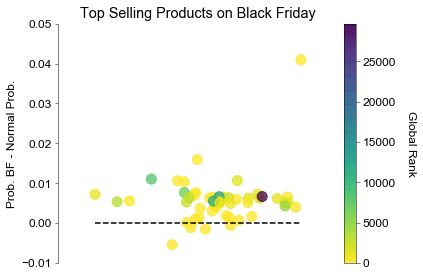

In [25]:
# black friday products ordered by descendingly
top_bf = bf_vs_non[:50]

y = top_bf['bf_probability'] - top_bf['non_bf_probability']
x = np.random.normal(1, 0.05, len(y))

fig, ax = plt.subplots()
plt.ylabel('Prob. BF - Normal Prob.')
sc = plt.scatter(x, y, alpha= 0.75, c= top_bf['non_bf_rank'], s= 100, cmap='viridis_r');
plt.ylim(-0.01, 0.05)
ax = default_plot(ax, 'left')
ax.get_xaxis().set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.hlines(0, min(x), max(x), ls='dashed')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Global Rank', rotation=270, labelpad = 20)
plt.title('Top Selling Products on Black Friday')
plt.tight_layout()
plt.savefig('figures/bf_products.png', dpi= 300)

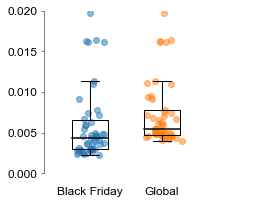

In [26]:
global_top = non_bf_products_prob['non_bf_probability'].sort_values(ascending=False).values[:50]
bf_top = bf_vs_non['non_bf_probability'].sort_values(ascending=False).values[:50]

# make figure
fig, ax = plt.subplots(figsize=(4, 3))
ax = default_plot(ax, ['bottom', 'left'])
ax.spines["bottom"].set_visible(False)
ax.set_xticklabels(['Black Friday', 'Global'])
plt.ylim(0, 0.02)
plt.xlim(0.25, 1.75)
medianprops = dict(linestyle='-', linewidth=1.5, color='black')
ax.scatter(np.random.normal(0.5, 0.05, len(bf_top)), bf_top, alpha= 0.5)
ax.scatter(np.random.normal(1, 0.05, len(bf_top)), global_top, alpha= 0.5)
ax.tick_params(axis='x',length=0)
ax.boxplot([bf_top, global_top], positions=[0.5, 1],showfliers= False, widths= 0.25, medianprops=medianprops);
plt.tight_layout()
plt.savefig('figures/bf_vs_global_prob.png', dpi= 300)

In [27]:
stats.ttest_ind(bf_top, global_top)

Ttest_indResult(statistic=-1.402741040425056, pvalue=0.16385419451707867)

*It seems that the top products sold on Black Friday are products which usually sell well*

### Customers
- Every order assigns a new customer ID even if it is a return customer.
- The unique customer ID can be found on the customers dataset
- How much does the average customer spend?
- How does it compare across regions?

In [28]:
# merge customers dataset with orders and payments dataset.
pay_ord_cust = orders.merge(payments, on='order_id', how='outer').merge(customers, on='customer_id', how='outer')
customer_spent = pay_ord_cust.groupby('customer_unique_id').agg({'payment_value': 'sum'}).sort_values(by='payment_value', ascending=False)

# calculating mean customer spent and standard deviation
customer_mean = customer_spent['payment_value'].mean()
customer_std = stats.sem(customer_spent['payment_value'])

# estimating population average from sample
stats.t.interval(0.95, loc=customer_mean, scale= customer_std, df= len(customer_spent)- 1)

# estimate mean and confidence interval for customers in each region
customer_regions = pay_ord_cust.groupby('customer_state').agg({'payment_value':[np.mean, np.std], 'customer_unique_id':'count'})
customer_regions.reset_index(inplace=True)

cis = stats.t.interval(.95, loc=customer_regions['payment_value']['mean'], scale=customer_regions['payment_value']['std']/np.sqrt(customer_regions['customer_unique_id']['count']), df= customer_regions['customer_unique_id']['count'] -1)

customer_regions['ci_low'] = cis[0]
customer_regions['ci_hi'] = cis[1]


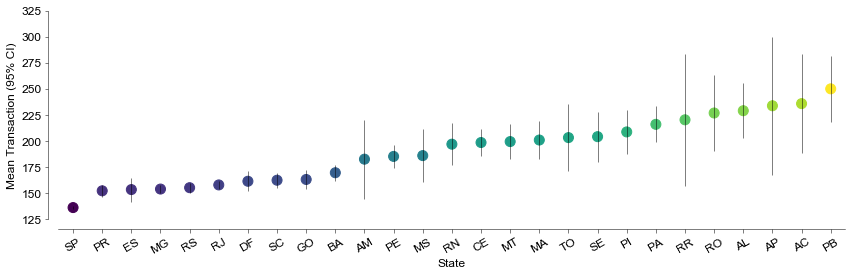

In [29]:
# sort ascendingly for easier to read plot
plot = customer_regions.sort_values(by=('payment_value', 'mean'))

# make figure
fig, ax = plt.subplots(figsize= (12, 4))
ax = default_plot(ax, ['left', 'bottom'])
plt.xticks(rotation= 30)
plt.xlabel('State')
plt.ylabel('Mean Transaction (95% CI)')
plt.xlim(-0.5, 26.5)
plt.ylim(125, 325)
plt.scatter(plot['customer_state'], plot['payment_value']['mean'], s=100, c=plot['payment_value']['mean'])
plt.vlines(plot['customer_state'], plot['ci_low'], plot['ci_hi'], lw=.5)
plt.tight_layout()
plt.savefig('figures/customers_ci.png', dpi= 300)

C:\Users\Zaca\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


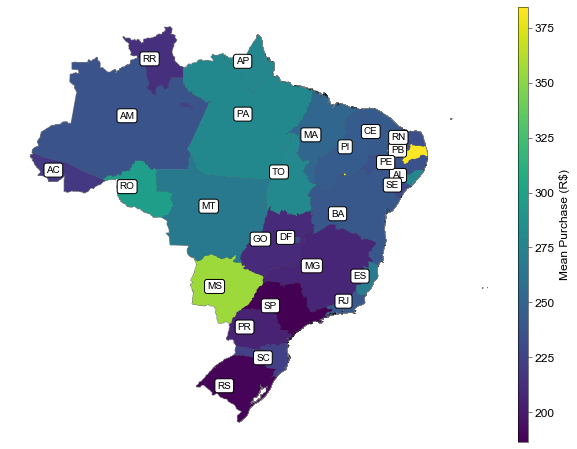

In [30]:
# make brazilian heatmap
customer_regions.rename(columns={'customer_state':'state'}, inplace=True)
brazil_map(customer_regions[['state', 'payment_value']], 'viridis', 'Mean Purchase (R$)')

### Sellers
- How much does the average seller sell?
- How does it compare across regions?

In [31]:
# merge to get seller id
seller_data = data['orders'].merge(data['items'], on= 'order_id', how= 'inner').merge(data['sellers'], on='seller_id', how='inner')

# calculate order price
seller_data['order_value'] = seller_data.order_item_id * seller_data.price + seller_data.freight_value

# get highest sellers
seller_sum = seller_data.groupby('seller_id').agg({'order_value':'sum'})

# calculating mean customer spent and standard deviation
seller_mean = seller_sum['order_value'].mean()
seller_std = stats.sem(seller_sum['order_value'])

# estimating population average from sample
stats.t.interval(0.95, loc=seller_mean, scale= seller_std, df= len(seller_sum) - 1)

# estimate mean and confidence interval for customers in each region
seller_regions = seller_data.groupby('seller_state').agg({'order_value':[np.mean, np.std], 'seller_id':'count'})
seller_regions.reset_index(inplace=True)

cis = stats.t.interval(.95, loc=seller_regions['order_value']['mean'], scale=seller_regions['order_value']['std']/np.sqrt(seller_regions['seller_id']['count']), df= seller_regions['seller_id']['count'] -1)

seller_regions['ci_low'] = cis[0]
seller_regions['ci_hi'] = cis[1]


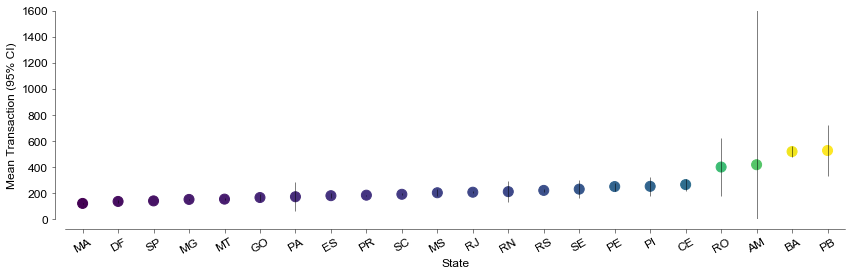

In [32]:
# sort ascendingly for easier to read plot
plot = seller_regions.sort_values(by=('order_value', 'mean'))

# make figure
fig, ax = plt.subplots(figsize= (12, 4))
ax = default_plot(ax, ['left', 'bottom'])
plt.xticks(rotation= 30)
plt.xlabel('State')
plt.ylabel('Mean Transaction (95% CI)')
plt.xlim(-0.5, 21.5)
plt.ylim(0, 1600)
plt.scatter(plot['seller_state'], plot['order_value']['mean'], s=100, c=plot['order_value']['mean'])
plt.vlines(plot['seller_state'], plot['ci_low'], plot['ci_hi'], lw=.5)
plt.tight_layout()
plt.savefig('figures/sellers_ci.png', dpi= 300)

C:\Users\Zaca\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


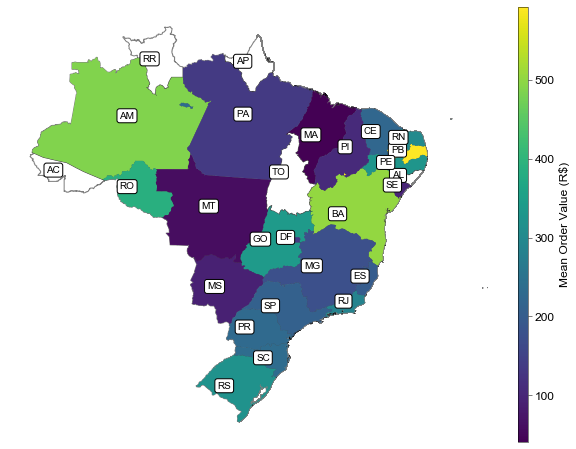

In [33]:
# make brazilian heatmap
seller_regions.rename(columns={'seller_state':'state'}, inplace=True)
brazil_map(seller_regions[['state', 'order_value']], 'viridis', 'Mean Order Value (R$)')

In [34]:
len(products)

32951